# Classification

A notebook reproducing some classification examples from Elements of Statistical Learning.

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.linalg as spl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
from mlalgos.supervised_learning.linear_regression import LinearRegression
from mlalgos.supervised_learning.knn import kNN
from mlalgos.supervised_learning.lda import LDA
from mlalgos.supervised_learning.qda import QDA
from mlalgos.supervised_learning.logistic_regression import LogisticRegression
from mlalgos.utils.data_utils import polynomial_features
from mlalgos.utils.error_funcs import misclassification_error

# Generate some data

In [3]:
class DataGenerator():
    def __init__(self):
        # The distributions to generate fake data from following Chapter 2 of ESL
        self.means0 = sps.multivariate_normal(mean=[1,0], cov=np.eye(2)).rvs(10)
        self.means1 = sps.multivariate_normal(mean=[0,1], cov=np.eye(2)).rvs(10)
        self.gaussians0 = [sps.multivariate_normal(mean=m, cov=np.eye(2)/5) for m in self.means0]
        self.gaussians1 = [sps.multivariate_normal(mean=m, cov=np.eye(2)/5) for m in self.means1]

    def generate0(self, N):
        """
        Generates N data points for class 0.
        """
        X0 = []
        for i in range(N):
            idx = np.random.randint(10)
            X0.append(self.gaussians0[idx].rvs())
        return np.array(X0)

    def generate1(self, N):
        """
        Generates N data points for class 1.
        """
        X1 = []
        for i in range(N):
            idx = np.random.randint(10)
            X1.append(self.gaussians1[idx].rvs())
        return np.array(X1)
    
    def generate(self, N):
        """
        Generate data for both classes.

        Args:
            N   (int): Number of data points in each class

        Returns:
            (np.array, np.array): The features and the classes
        """
        X0 = self.generate0(N)
        X1 = self.generate1(N)
        X = np.append(X0, X1, axis=0)
        Y = np.append(np.zeros(N), np.ones(N))
        return X, Y

generator = DataGenerator()
X, Y = generator.generate(200)

# Define some plotting functions
(Move to package later if reused?)

In [9]:
# Some colours
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
GREEN = '#009E73'

In [6]:
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    #ax.set_aspect(1.3)
    ax.scatter(X.T[0], X.T[1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[Y.astype(int)])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-3, 4.)
    ax.set_ylim(-3., 4)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-3, 4.2, title, color=GRAY4, fontsize=9)
    return fig, ax

In [7]:
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-3., 4., n1), np.linspace(-3., 4., n2)
    X = np.array([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X.T)
    return X, y>0.5

def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[0].reshape(n1, n2), X[1].reshape(n1, n2), y.reshape(n1, n2)

def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X.T[:, 0], X.T[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y.astype(int)])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

# Linear Classifier

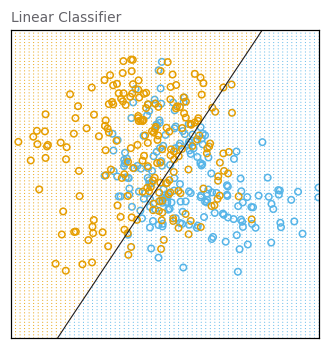

In [12]:
linear_classifier = LinearRegression()
linear_classifier.fit(X, Y)
linear_predict = linear_classifier.predict

fig_linear, _ = plot_model(linear_predict, 'Linear Classifier')

# $k$ Nearest Neighbours

In [55]:
knn = kNN(15)
knn.fit(X, Y)
knn_predict = knn.predict

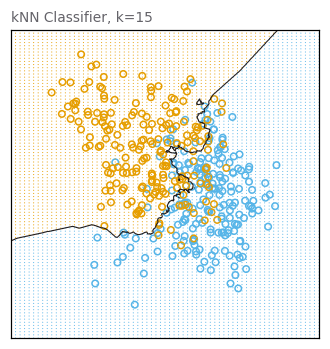

In [56]:
fig_knn15, _ = plot_model(knn_predict, 'kNN Classifier, k=15')

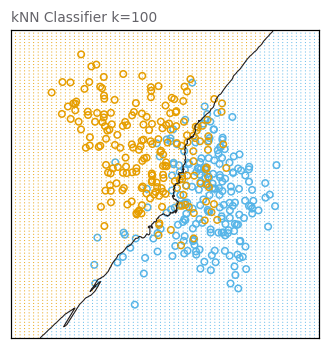

In [57]:
knn100 = kNN(k=100)
knn100.fit(X, Y)
_, _ = plot_model(knn100.predict, 'kNN Classifier k=100')

# Optimal Bayes

Since we know the generating distributions, we can use an optimal Bayes classifier and compare the results

In [58]:
class OptimalBayes():
    def __init__(self, datagenerator):
        self.gaussians0 = datagenerator.gaussians0
        self.gaussians1 = datagenerator.gaussians1
    def predict(self, x):
        n = len(self.gaussians0)
        p0 = (1./n) * np.sum(np.array([g.pdf(x) for g  in self.gaussians0]),axis=0)
        p1 = (1./n) * np.sum(np.array([g.pdf(x) for g  in self.gaussians1]),axis=0)
        return (p1 > p0).astype(int)

optimal_bayes = OptimalBayes(generator)

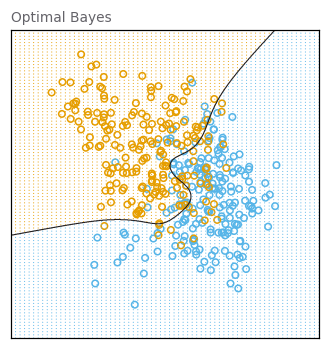

In [59]:
fig_bayes, _ = plot_model(optimal_bayes.predict, 'Optimal Bayes')

# Compare kNN performance to optimal Bayes

In [60]:
# Generate test data
Xtest, Ytest = generator.generate(5000)

def err(y, y_true):
    return np.sum(y != y_true)/np.shape(y_true)[0]

In [61]:
lin_train_err = err((linear_predict(X)>0.5).astype(int), Y)
lin_test_err = err((linear_predict(Xtest)>0.5).astype(int), Ytest)

In [62]:
opt_bayes_err = err(optimal_bayes.predict(Xtest), Ytest)

In [63]:
ks = [1, 3, 5, 7, 11, 15, 20, 30, 45, 60, 80, 110, 150, 199]
knn_train_err = []
knn_test_err = []
for k in ks:
    knn_model = kNN(k=k)
    knn_model.fit(X, Y)
    knn_train_err.append(err(knn_model.predict(X), Y))
    knn_test_err.append(err(knn_model.predict(Xtest), Ytest))

In [64]:
dof = 200/np.array(ks)

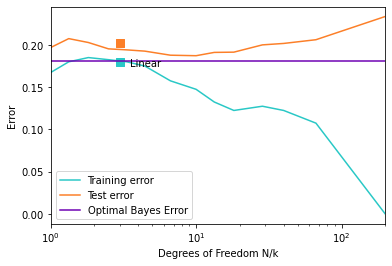

In [65]:
fig, ax = plt.subplots()
ax.plot(dof[::-1], knn_train_err[::-1], c='#29C8C6', label='Training error')
ax.plot(dof[::-1], knn_test_err[::-1], c='#FC7F28', label='Test error')
ax.scatter([3], [lin_train_err], c='#29C8C6', s=50, marker='s')
ax.scatter([3], [lin_test_err], c='#FC7F28', s=50, marker='s')
ax.text(3.5, lin_train_err-0.005, 'Linear')
ax.axhline(opt_bayes_err, c='#6D00B2', label='Optimal Bayes Error')
ax.set_xscale('log')
ax.set_xlabel('Degrees of Freedom N/k')
ax.set_ylabel('Error')
ax.set_xbound([1,200])
ax.legend()

# Linear Discriminant Analysis

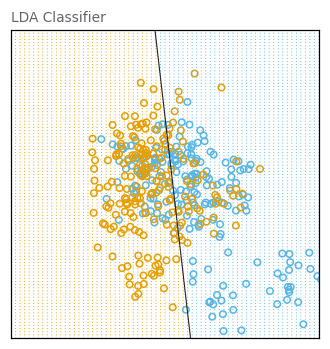

In [7]:
lda_classifier = LDA()
lda_classifier.fit(X, Y)
lda_predict = lda_classifier.predict

fig_lda, _ = plot_model(lda_predict, 'LDA Classifier')

In [3]:
# Generate some data with three classes

class DataGenerator3Classes():
    def __init__(self):
        self.mean0 = [-1, -1]
        self.mean1 = [1, -1]
        self.mean2 = [0, 1]
        self.cov = np.array([[0.5, 0.25], [0.25, 0.5]])
        self.gaussian0 = sps.multivariate_normal(mean=self.mean0, cov=self.cov)
        self.gaussian1 = sps.multivariate_normal(mean=self.mean1, cov=self.cov)
        self.gaussian2 = sps.multivariate_normal(mean=self.mean2, cov=self.cov)

    def generate_class(self, N, dist):
        """
        Generates N data points for a class.
        """
        X = []
        for i in range(N):
            X.append(dist.rvs())
        return np.array(X)

    def generate(self, N):
        """
        Generate data for all classes.

        Args:
            N   (int): Number of data points in each class

        Returns:
            (np.array, np.array): The features and the classes
        """
        X0 = self.generate_class(N, self.gaussian0)
        X1 = self.generate_class(N, self.gaussian1)
        X2 = self.generate_class(N, self.gaussian2)
        X = np.append(X0, np.append(X1, X2, axis=0), axis=0)
        Y = np.append(np.zeros(N), np.append(np.ones(N), 2*np.ones(N)))
        return X, Y

generator3 = DataGenerator3Classes()
X, Y = generator3.generate(200)

In [18]:
# Modify the plotting functions

def plot_train_data3(title):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    #ax.set_aspect(1.3)
    ax.scatter(X.T[0], X.T[1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE, GREEN])[Y.astype(int)])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-3, 4.)
    ax.set_ylim(-3., 4)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-3, 4.2, title, color=GRAY4, fontsize=9)
    return fig, ax

def fill_prediction_grid3(n1, n2, predict, degree=1):
    x1, x2 = np.linspace(-3., 4., n1), np.linspace(-3., 4., n2)
    X = np.array([np.tile(x1, n2), np.repeat(x2, n1)])
    if degree == 1:
        y = predict(X.T)
    else:
        y = predict(polynomial_features(X.T, degree))
    return X, y

def fill_prediction_meshgrid3(predict, degree=1):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid3(n1, n2, predict, degree)
    return X[0].reshape(n1, n2), X[1].reshape(n1, n2), y.reshape(n1, n2)

def plot_model3(predict, title, degree=1):
    fig, ax = plot_train_data3(title)
    # plot background dots
    X, y = fill_prediction_grid3(69, 99, predict, degree)
    ax.scatter(X.T[:, 0], X.T[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE, GREEN])[y.astype(int)])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid3(predict, degree)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    ax.contour(X0, X1, Y, [1.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

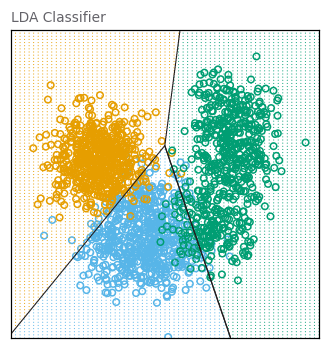

In [21]:
lda_classifier = LDA()
lda_classifier.fit(X, Y)
lda_predict = lda_classifier.predict

fig_lda, _ = plot_model3(lda_predict, 'LDA Classifier')


# Quadratic Discriminant Analysis

In [24]:
# Generate some data with three classes from Gaussian mixtures

class DataGenerator3ClassesMixture():
    def __init__(self):
        self.means0 = [[-0.5, -1], [0, -0.1], [0.5, -1]]
        self.means1 = [[-1, 1], [-1.2, 1.1], [-0.8, 1.1]]
        self.means2 = [[2, 1], [2, 2], [1.5, -0.5]]
        self.cov = np.array([[0.25, 0], [0, 0.25]])
        self.gaussians0 = [sps.multivariate_normal(mean=m, cov=self.cov) for m in self.means0]
        self.gaussians1 = [sps.multivariate_normal(mean=m, cov=self.cov) for m in self.means1]
        self.gaussians2 = [sps.multivariate_normal(mean=m, cov=self.cov) for m in self.means2]

    def generate_class(self, N, dists):
        """
        Generates N data points for a class.
        Uses equal mixtures.
        """
        X = []
        n = int(N/len(dists))
        for i in range(n):
            for dist in dists:
                X.append(dist.rvs())
        while len(X) < N:
            X.append(dist.rvs())

        return np.array(X)

    def generate(self, N):
        """
        Generate data for all classes.

        Args:
            N   (int): Number of data points in each class

        Returns:
            (np.array, np.array): The features and the classes
        """
        X0 = self.generate_class(N, self.gaussians0)
        X1 = self.generate_class(N, self.gaussians1)
        X2 = self.generate_class(N, self.gaussians2)
        X = np.append(X0, np.append(X1, X2, axis=0), axis=0)
        Y = np.append(np.zeros(N), np.append(np.ones(N), 2*np.ones(N)))
        return X, Y

generator3 = DataGenerator3ClassesMixture()
X, Y = generator3.generate(200)


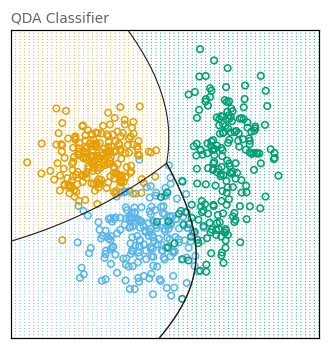

In [25]:
qda_classifier = QDA()
qda_classifier.fit(X, Y)
qda_predict = qda_classifier.predict

fig_qda, _ = plot_model3(qda_predict, 'QDA Classifier')


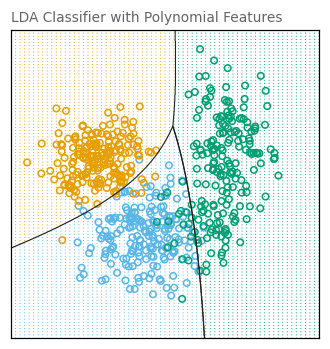

In [26]:
X_polynomial = polynomial_features(X, 2)

lda_classifier = LDA()
lda_classifier.fit(X_polynomial, Y)
lda_predict = lda_classifier.predict

fig_lda, _ = plot_model3(lda_predict, 'LDA Classifier with Polynomial Features', degree=2)

## Vowel data

In [3]:
# Load the training data
vowel_train = pd.read_csv('~/datasets/vowel/vowel.train')
vowel_train.head

<bound method NDFrame.head of      row.names   y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8  \
0            1   1 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388  0.529   
1            2   2 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363  0.510   
2            3   3 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579  0.676   
3            4   4 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567  0.235   
4            5   5 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394 -0.150   
..         ...  ..    ...    ...    ...    ...    ...    ...    ...    ...   
523        524   7 -4.065  2.876 -0.856 -0.221 -0.533  0.232  0.855  0.633   
524        525   8 -4.513  4.265 -1.477 -1.090  0.215  0.829  0.342  0.693   
525        526   9 -4.651  4.246 -0.823 -0.831  0.666  0.546 -0.300  0.094   
526        527  10 -5.034  4.993 -1.633 -0.285  0.398  0.181 -0.211 -0.508   
527        528  11 -4.261  1.827 -0.482 -0.194  0.731  0.354 -0.478  0.050   

       x.9   x.10  
0   -0.874 -0

In [4]:
# Shift the y-values so the go from 0 to 10 instead of 1 to 11
y_train = vowel_train.iloc[:, 1].to_numpy() - 1
X_train = vowel_train.iloc[:, 2:].to_numpy()

In [5]:
y_train.shape

(528,)

In [6]:
X_train.shape

(528, 10)

In [7]:
lda_transform = LDA()
lda_transform.fit(X_train, y_train)
X_transformed = lda_transform.transform(X_train, X_train.shape[1])

In [9]:
n_classes = len(np.unique(y_train))
centroids = []
for cl in range(n_classes):
    centroids.append(np.mean(X_transformed[y_train == cl], axis=0))

In [17]:
centroids[0][0]

-3.31374155769803

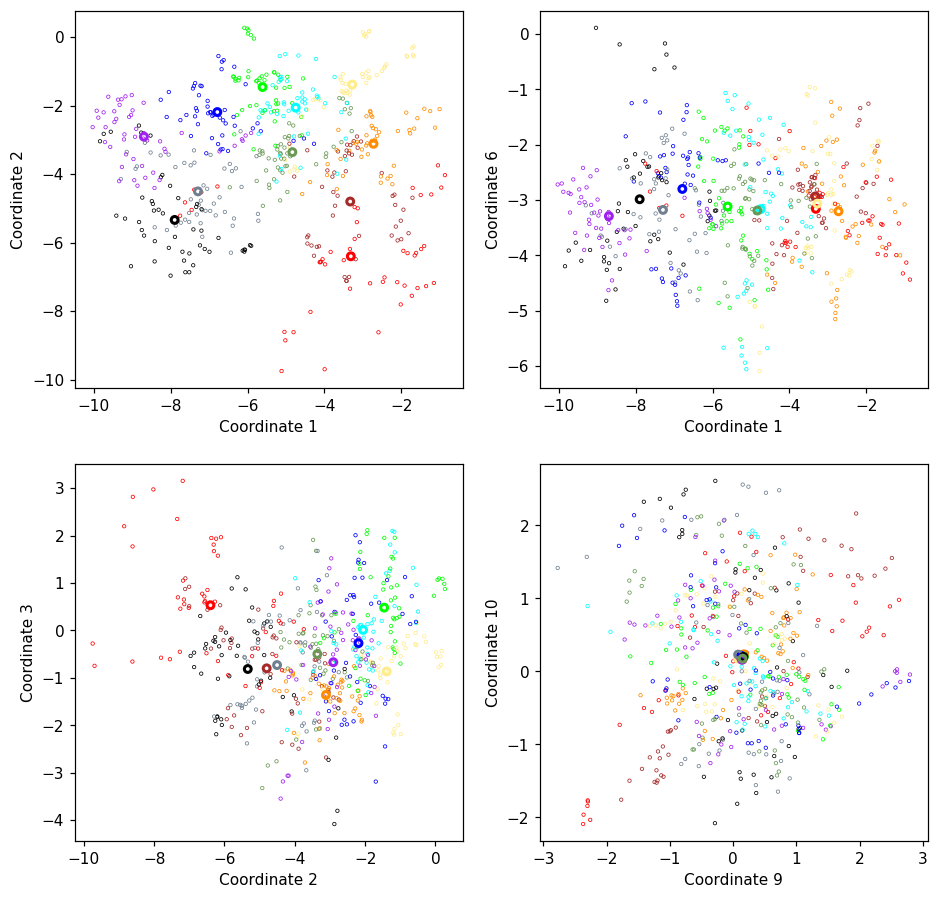

In [34]:
colours = ['#FF0000', '#A52A2A', '#FF8C00', '#FFEC8B', '#00FF00', '#00FFFF', '#0000FF', '#A020F0', '#708090', '#000000', '#6A9955']
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=110)

ax[0, 0].scatter(X_transformed[:, 0], X_transformed[:, 1], marker='o', facecolors='none', edgecolors=np.array(colours)[y_train.astype(int)], s=5, linewidth=0.5)
for i in range(len(centroids)):
    ax[0, 0].scatter(centroids[i][0], centroids[i][1], edgecolors=colours[i], facecolors='None', s=20, linewidth=2)
ax[0, 0].set(xlabel='Coordinate 1', ylabel='Coordinate 2')

ax[1, 0].scatter(X_transformed[:, 1], X_transformed[:, 2], marker='o', facecolors='none', edgecolors=np.array(colours)[y_train.astype(int)], s=5, linewidth=0.5)
for i in range(len(centroids)):
    ax[1, 0].scatter(centroids[i][1], centroids[i][2], edgecolors=colours[i], facecolors='None', s=20, linewidth=2)
ax[1, 0].set(xlabel='Coordinate 2', ylabel='Coordinate 3')

ax[0, 1].scatter(X_transformed[:, 0], X_transformed[:, 6], marker='o', facecolors='none', edgecolors=np.array(colours)[y_train.astype(int)], s=5, linewidth=0.5)
for i in range(len(centroids)):
    ax[0, 1].scatter(centroids[i][0], centroids[i][6], edgecolors=colours[i], facecolors='None', s=20, linewidth=2)
ax[0, 1].set(xlabel='Coordinate 1', ylabel='Coordinate 6')

ax[1, 1].scatter(X_transformed[:, 8], X_transformed[:, 9], marker='o', facecolors='none', edgecolors=np.array(colours)[y_train.astype(int)], s=5, linewidth=0.5)
for i in range(len(centroids)):
    ax[1, 1].scatter(centroids[i][8], centroids[i][9], edgecolors=colours[i], facecolors='None', s=20, linewidth=2)
ax[1, 1].set(xlabel='Coordinate 9', ylabel='Coordinate 10')

plt.show()

In [35]:
vowel_test = pd.read_csv('~/datasets/vowel/vowel.test')
vowel_test.head

# Shift the y-values so the go from 0 to 10 instead of 1 to 11
y_test = vowel_test.iloc[:, 1].to_numpy() - 1
X_test = vowel_test.iloc[:, 2:].to_numpy()

In [38]:
# Transform the test data according to the fitted parameters from the train data.
# Then pick out the N first coordinates, train a classifier on the transformed train data and classify the test data

X_test_transformed = lda_transform.transform(X_test, 10)

In [43]:
train_errors = []
test_errors = []

for i in range(1, 10):
    lda_classifier = LDA()
    lda_classifier.fit(X_transformed[:, :i], y_train)
    train_errors.append(misclassification_error(y_train, lda_classifier.predict(X_transformed[:, :i])))
    test_errors.append(misclassification_error(y_test, lda_classifier.predict(X_test_transformed[:, :i])))

In [44]:
print(train_errors)
print(test_errors)

[0.6117424242424243, 0.3503787878787879, 0.32954545454545453, 0.32954545454545453, 0.3162878787878788, 0.30113636363636365, 0.3125, 0.3181818181818182, 0.3143939393939394]
[0.6991341991341992, 0.49134199134199136, 0.49567099567099565, 0.5108225108225108, 0.5151515151515151, 0.5541125541125541, 0.5541125541125541, 0.5562770562770563, 0.551948051948052]


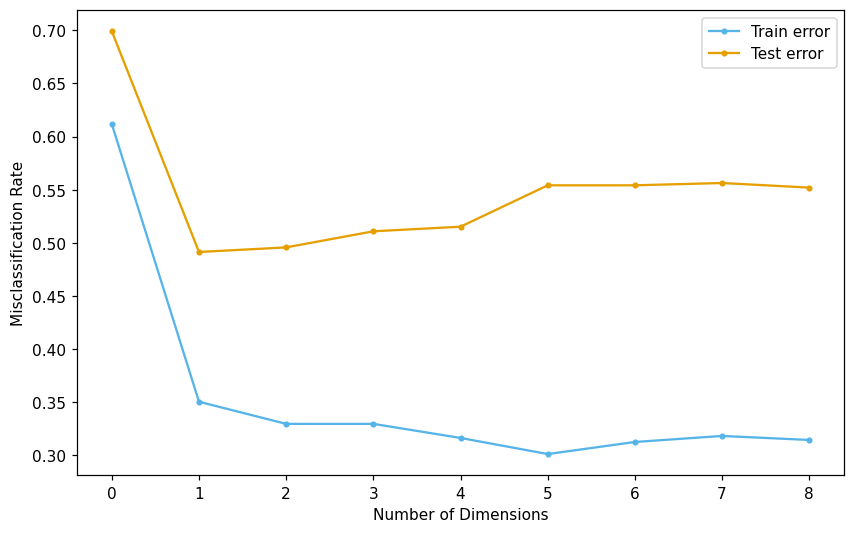

In [58]:
fig, ax = plt.subplots(figsize=(9, 5.6), dpi=110)
ax.plot(train_errors, linestyle='-', marker='o', c='#56B4E9', markersize=3, label='Train error')
ax.plot(test_errors, linestyle='-', marker='o', c='#E69F00', markersize=3, label='Test error')
ax.set_xlabel('Number of Dimensions')
ax.set_ylabel('Misclassification Rate')
ax.legend()
plt.show()

# Logistic Regression

In [3]:
sa_heart_data = pd.read_csv('~/datasets/SAheart.data.txt')
sa_heart_data = sa_heart_data.replace(regex={"^Present": 1., "^Absent": 0.})
sa_heart_data.head

<bound method NDFrame.head of      row.names  sbp  tobacco    ldl  adiposity  famhist  typea  obesity  \
0            1  160    12.00   5.73      23.11      1.0     49    25.30   
1            2  144     0.01   4.41      28.61      0.0     55    28.87   
2            3  118     0.08   3.48      32.28      1.0     52    29.14   
3            4  170     7.50   6.41      38.03      1.0     51    31.99   
4            5  134    13.60   3.50      27.78      1.0     60    25.99   
..         ...  ...      ...    ...        ...      ...    ...      ...   
457        459  214     0.40   5.98      31.72      0.0     64    28.45   
458        460  182     4.20   4.41      32.10      0.0     52    28.61   
459        461  108     3.00   1.59      15.23      0.0     40    20.09   
460        462  118     5.40  11.61      30.79      0.0     64    27.35   
461        463  132     0.00   4.82      33.41      1.0     62    14.70   

     alcohol  age  chd  
0      97.20   52    1  
1       2.06   63  

In [4]:
sa_heart_data.columns

Index(['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea',
       'obesity', 'alcohol', 'age', 'chd'],
      dtype='object')

array([[<AxesSubplot:xlabel='sbp', ylabel='sbp'>,
        <AxesSubplot:xlabel='tobacco', ylabel='sbp'>,
        <AxesSubplot:xlabel='ldl', ylabel='sbp'>,
        <AxesSubplot:xlabel='famhist', ylabel='sbp'>,
        <AxesSubplot:xlabel='obesity', ylabel='sbp'>,
        <AxesSubplot:xlabel='alcohol', ylabel='sbp'>,
        <AxesSubplot:xlabel='age', ylabel='sbp'>],
       [<AxesSubplot:xlabel='sbp', ylabel='tobacco'>,
        <AxesSubplot:xlabel='tobacco', ylabel='tobacco'>,
        <AxesSubplot:xlabel='ldl', ylabel='tobacco'>,
        <AxesSubplot:xlabel='famhist', ylabel='tobacco'>,
        <AxesSubplot:xlabel='obesity', ylabel='tobacco'>,
        <AxesSubplot:xlabel='alcohol', ylabel='tobacco'>,
        <AxesSubplot:xlabel='age', ylabel='tobacco'>],
       [<AxesSubplot:xlabel='sbp', ylabel='ldl'>,
        <AxesSubplot:xlabel='tobacco', ylabel='ldl'>,
        <AxesSubplot:xlabel='ldl', ylabel='ldl'>,
        <AxesSubplot:xlabel='famhist', ylabel='ldl'>,
        <AxesSubplot:xlabel='o

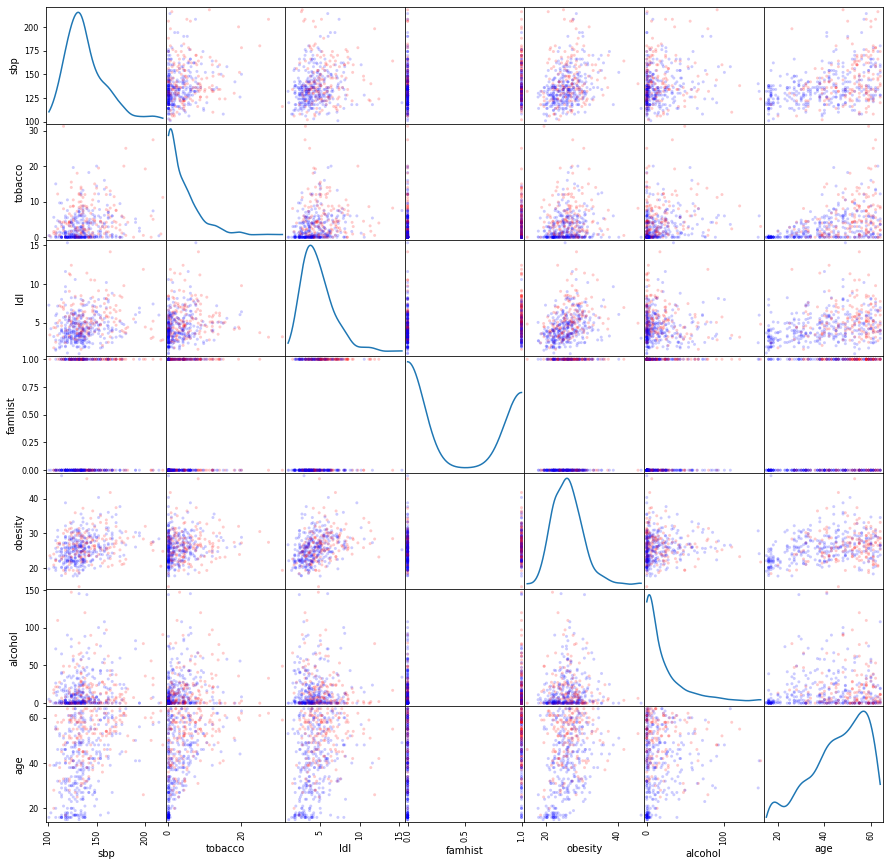

In [5]:
pd.plotting.scatter_matrix(sa_heart_data[["sbp", "tobacco", "ldl", "famhist", "obesity", "alcohol", "age"]], alpha=0.2, figsize=(15, 15), diagonal='kde', c=sa_heart_data["chd"], cmap='bwr')

In [6]:
log_reg = LogisticRegression()
col_names = ["sbp", "tobacco", "ldl", "famhist", "obesity", "alcohol", "age"]
log_reg.fit(sa_heart_data[col_names].to_numpy(), sa_heart_data["chd"].to_numpy(), tol=1.e-5)

In [7]:
coeffs, errors = log_reg.get_coefficients_and_errors()

In [8]:
def z_score(coeffs, errors, col_names):
    coeffs = coeffs.reshape((coeffs.shape[0],))
    zs = coeffs/errors
    par_names = ["(intercept)"] + [col + "\t" for col in col_names]
    table = (f"Name\t\t | \tCoefficient\t | \t   Std. Error\t\t | \t\tZ-score\n"
            f"-----------------+-----------------------+-------------------------------+----------------------\n")
    for i in range(len(coeffs)):
        table += f"{par_names[i]}\t | \t{coeffs[i]:.3f}\t\t | \t\t{errors[i]:.3f}\t\t | \t\t{zs[i]:.2f}\n"
    print(table)

In [9]:
z_score(coeffs, errors, col_names)

Name		 | 	Coefficient	 | 	   Std. Error		 | 		Z-score
-----------------+-----------------------+-------------------------------+----------------------
(intercept)	 | 	-4.130		 | 		0.964		 | 		-4.28
sbp		 | 	0.006		 | 		0.006		 | 		1.02
tobacco		 | 	0.080		 | 		0.026		 | 		3.03
ldl		 | 	0.185		 | 		0.057		 | 		3.22
famhist		 | 	0.939		 | 		0.225		 | 		4.18
obesity		 | 	-0.035		 | 		0.029		 | 		-1.19
alcohol		 | 	0.001		 | 		0.004		 | 		0.14
age		 | 	0.043		 | 		0.010		 | 		4.18



Remove the variables with an absolute z-score less than 2.

In [10]:
log_reg_parsimonious = LogisticRegression()
parsimonious_col_names = ["tobacco", "ldl", "famhist", "age"]
log_reg_parsimonious.fit(sa_heart_data[parsimonious_col_names].to_numpy(), sa_heart_data["chd"].to_numpy(), tol=1.e-5)

In [11]:
coeffs, errors = log_reg_parsimonious.get_coefficients_and_errors()
z_score(coeffs, errors, parsimonious_col_names)

Name		 | 	Coefficient	 | 	   Std. Error		 | 		Z-score
-----------------+-----------------------+-------------------------------+----------------------
(intercept)	 | 	-4.204		 | 		0.498		 | 		-8.44
tobacco		 | 	0.081		 | 		0.026		 | 		3.16
ldl		 | 	0.168		 | 		0.054		 | 		3.09
famhist		 | 	0.924		 | 		0.223		 | 		4.14
age		 | 	0.044		 | 		0.010		 | 		4.52

